# Laboratorio 3 - Parte 1
## Cifrado de Información
### José Daniel Gómez Cabrera 21429

In [21]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad
from Crypto.Random import get_random_bytes
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

In [22]:
# esta funcion me ayuda a leer un archivo de imagen en formato PPM
def read_ppm(filename):
    with open(filename, 'rb') as f:
        line = f.readline()
        while line.startswith(b'#'):
            line = f.readline()
        dimensions = f.readline().split()
        width = int(dimensions[0])
        height = int(dimensions[1])
        f.readline()
        data = f.read(width * height * 3)
        img = np.frombuffer(data, dtype=np.uint8).reshape((height, width, 3))
        if img.shape[2] == 3:
            img_gray = np.mean(img, axis=2).astype(np.uint8)
            return img_gray
        return img

In [23]:
# esta funcion me ayuda a guardar un archivo de imagen en formato PPM
def save_ppm(filename, img):
    height, width = img.shape
    with open(filename, 'wb') as f:
        f.write(b'P5\n') # escala de grises con 5 dimensiones
        f.write(f'{width} {height}\n'.encode())
        f.write(b'255\n')
        f.write(img.tobytes())

### Funcion para encriptar imagenes con AES en modo ECB

In [24]:
def encrypt_image_ecb(img, key):
    height, width = img.shape
    padded_width = ((width + 15) // 16) * 16
    padded_img = np.zeros((height, padded_width), dtype=np.uint8)
    padded_img[:, :width] = img

    cipher = AES.new(key, AES.MODE_ECB)

    encrypted_img = np.zeros_like(padded_img)
    for i in range(height):
        encrypted_row = cipher.encrypt(padded_img[i].tobytes())
        encrypted_img[i] = np.frombuffer(encrypted_row, dtype=np.uint8)

    return encrypted_img[:, :width]

### Funcion para encriptar imagenes con AES en modo CBC

In [25]:
def encrypt_image_cbc(img, key):
    height, width = img.shape
    padded_width = ((width + 15) // 16) * 16
    padded_img = np.zeros((height, padded_width), dtype=np.uint8)
    padded_img[:, :width] = img

    iv = get_random_bytes(16)

    cipher = AES.new(key, AES.MODE_CBC, iv)

    encrypted_img = np.zeros_like(padded_img)
    for i in range(height):
        encrypted_row = cipher.encrypt(padded_img[i].tobytes())
        cipher = AES.new(key, AES.MODE_CBC, iv)
        encrypted_img[i] = np.frombuffer(encrypted_row, dtype=np.uint8)

    return encrypted_img[:, :width]

#### Pruebas de las funciones

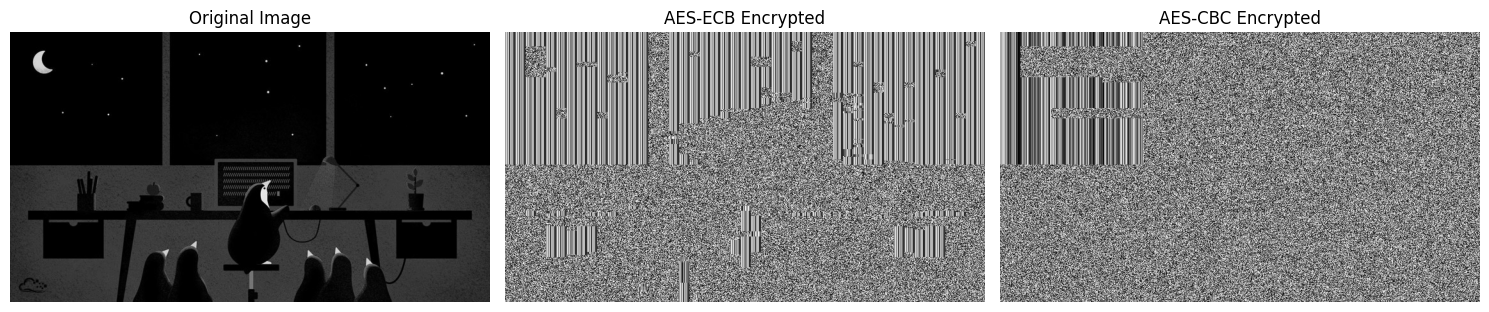

In [26]:
file = "linux.ppm"

if file.lower().endswith('.bmp'):
    img = np.array(Image.open(file).convert('L'))
else:
    img = read_ppm(file)

key = get_random_bytes(16)  # 128-bit key

encrypted_ecb = encrypt_image_ecb(img, key)

encrypted_cbc = encrypt_image_cbc(img, key)

# comparamos las imagenes entre si
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(encrypted_ecb, cmap='gray')
plt.title('AES-ECB Encrypted')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(encrypted_cbc, cmap='gray')
plt.title('AES-CBC Encrypted')
plt.axis('off')

plt.tight_layout()
plt.savefig('encryption_comparison.png')
plt.show()

save_ppm('encrypted_ecb.ppm', encrypted_ecb)
save_ppm('encrypted_cbc.ppm', encrypted_cbc)